### <h1><center>Explore and cluster the neighborhoods in Toronto</center></h1>

### 1. Get data into a dataframe

In [1]:
pip install lxml

Note: you may need to restart the kernel to use updated packages.


In [1]:
import pandas as pd
df_canada = pd.read_html('https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M')[0]

# Ignore cells with a borough that is Not assigned
df_canada = df_canada[df_canada['Borough'] != "Not assigned"]
df_canada.reset_index(drop=True, inplace=True)
df_canada.head()

,Postal Code,Borough,Neighborhood
0,M3A,North York,Parkwoods
1,M4A,North York,Victoria Village
2,M5A,Downtown Toronto,"Regent Park, Harbourfront"
3,M6A,North York,"Lawrence Manor, Lawrence Heights"
4,M7A,Downtown Toronto,"Queen's Park, Ontario Provincial Government"


#### Where more than one neighborhood exists in one postal code area, combine into one row with the neighborhoods

In [2]:
df_canada.groupby('Postal Code')['Neighborhood'].apply(' '.join).reset_index()
df_canada.head()

,Postal Code,Borough,Neighborhood
0,M3A,North York,Parkwoods
1,M4A,North York,Victoria Village
2,M5A,Downtown Toronto,"Regent Park, Harbourfront"
3,M6A,North York,"Lawrence Manor, Lawrence Heights"
4,M7A,Downtown Toronto,"Queen's Park, Ontario Provincial Government"


### Part 2. Getting the latitude and the longitude coordinates of each neighborhood

In [3]:
df_cord = pd.read_csv('Geospatial_Coordinates.csv')
df_cord.head()

,Postal Code,Latitude,Longitude
0,M1B,43.806686,-79.194353
1,M1C,43.784535,-79.160497
2,M1E,43.763573,-79.188711
3,M1G,43.770992,-79.216917
4,M1H,43.773136,-79.239476


In [4]:
df_canada = pd.merge(df_canada, df_cord)
df_canada.head()

,Postal Code,Borough,Neighborhood,Latitude,Longitude
0,M3A,North York,Parkwoods,43.753259,-79.329656
1,M4A,North York,Victoria Village,43.725882,-79.315572
2,M5A,Downtown Toronto,"Regent Park, Harbourfront",43.654260,-79.360636
3,M6A,North York,"Lawrence Manor, Lawrence Heights",43.718518,-79.464763
4,M7A,Downtown Toronto,"Queen's Park, Ontario Provincial Government",43.662301,-79.389494


### 2. Explore the neighborhoods and venues in Toronto

__Download necessary dependencies__

In [5]:
import numpy as np # library to handle data in a vectorized manner

import pandas as pd # library for data analsysis
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

import json # library to handle JSON files

!conda install -c conda-forge geopy --yes 
!pip install geopy
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values

import requests # library to handle requests
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe

# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors

# import k-means from clustering stage
from sklearn.cluster import KMeans

!conda install -c conda-forge folium=0.5.0 --yes
import folium # map rendering library

print('Libraries imported.')

Solving environment: done

# All requested packages already installed.

Solving environment: failed with initial frozen solve. Retrying with flexible solve.
Solving environment: done

## Package Plan ##

  environment location: /home/jupyterlab/conda/envs/python

  added / updated specs:
    - folium=0.5.0


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    altair-4.1.0               |             py_1         614 KB  conda-forge
    branca-0.4.1               |             py_0          26 KB  conda-forge
    brotlipy-0.7.0             |py36h8c4c3a4_1000         346 KB  conda-forge
    chardet-3.0.4              |py36h9f0ad1d_1006         188 KB  conda-forge
    cryptography-2.9.2         |   py36h45558ae_0         613 KB  conda-forge
    folium-0.5.0               |             py_0          45 KB  conda-forge
    pandas-1.0.5               |   py36h830a2c2_0        10.1 MB  conda-forge


__Search for Toronto in the Borough column__

In [6]:
toronto_data = df_canada[df_canada['Borough'].str.contains('Toronto') == True].reset_index(drop=True)
toronto_data.head()

,Postal Code,Borough,Neighborhood,Latitude,Longitude
0,M5A,Downtown Toronto,"Regent Park, Harbourfront",43.654260,-79.360636
1,M7A,Downtown Toronto,"Queen's Park, Ontario Provincial Government",43.662301,-79.389494
2,M5B,Downtown Toronto,"Garden District, Ryerson",43.657162,-79.378937
3,M5C,Downtown Toronto,St. James Town,43.651494,-79.375418
4,M4E,East Toronto,The Beaches,43.676357,-79.293031


__Use geopy library to get the latitude and longitude values of Toronto__

In [7]:
address = 'Toronto, Ontario, Canada'

geolocator = Nominatim(user_agent="ny_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of Toronto are {}, {}.'.format(latitude, longitude))

The geograpical coordinate of Toronto are 43.6534817, -79.3839347.


__Create a map of Toronto with neighborhoods superimposed on top__

In [8]:
# Create map of Toronto using latitude and longitude values
map_toronto = folium.Map(location=[latitude, longitude], zoom_start=10)

# Add markers to map
for lat, lng, borough, neighborhood in zip(toronto_data['Latitude'], toronto_data['Longitude'], toronto_data['Borough'], toronto_data['Neighborhood']):
    label = '{}, {}'.format(neighborhood, borough)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius = 5,
        popup=label,
        colour='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_toronto)

map_toronto

__Use Foursquare API to explore the neighborhoods and segment them__

In [9]:
CLIENT_ID = 'IER0QGJOKI224HEQFP0REFN2HRTVAF3KF1RGZIYZ1UQ25SUA' # your Foursquare ID
CLIENT_SECRET = 'IQW2RKXEYEOC4HKHCVL1XCMFIJAHS5HG5BVEULWVHQKNEYTK' # your Foursquare Secret
VERSION = '20180605' # Foursquare API version

print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

Your credentails:
CLIENT_ID: IER0QGJOKI224HEQFP0REFN2HRTVAF3KF1RGZIYZ1UQ25SUA
CLIENT_SECRET:IQW2RKXEYEOC4HKHCVL1XCMFIJAHS5HG5BVEULWVHQKNEYTK


__Get the top 100 venues in Toronto within a radius of 500 meters__

Explore venues in Toronto. Cordinates for Toronto are as found earlier

In [10]:
radius = 500
LIMIT = 100
url = 'https://api.foursquare.com/v2/venues/explore?client_id={}&client_secret={}&ll={},{}&v={}&radius={}&limit={}'.format(CLIENT_ID, CLIENT_SECRET, latitude, longitude, VERSION, radius, LIMIT)
url

'https://api.foursquare.com/v2/venues/explore?client_id=IER0QGJOKI224HEQFP0REFN2HRTVAF3KF1RGZIYZ1UQ25SUA&client_secret=IQW2RKXEYEOC4HKHCVL1XCMFIJAHS5HG5BVEULWVHQKNEYTK&ll=43.6534817,-79.3839347&v=20180605&radius=500&limit=100'

Send the GET request and examine the resutls

In [11]:
results = requests.get(url).json()
results

Create function to get neighborhoods in Toronto

In [12]:
def getNearbyVenues(names, latitudes, longitudes, radius=500):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

__Venues in Toronto__

In [14]:
toronto_venues = getNearbyVenues(names=toronto_data['Neighborhood'],
                                   latitudes=toronto_data['Latitude'],
                                   longitudes=toronto_data['Longitude']
                                  )
# Total venues returned for Toronto
toronto_venues.shape

(1607, 7)

Number of venues were returned for each neighborhood

In [15]:
toronto_venues.groupby('Neighborhood').count()

,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
Neighborhood,,,,,,
Berczy Park,57,57,57,57,57,57
"Brockton, Parkdale Village, Exhibition Place",22,22,22,22,22,22
"Business reply mail Processing Centre, South Central Letter Processing Plant Toronto",15,15,15,15,15,15
"CN Tower, King and Spadina, Railway Lands, Harbourfront West, Bathurst Quay, South Niagara, Island airport",17,17,17,17,17,17
Central Bay Street,64,64,64,64,64,64
Christie,16,16,16,16,16,16
Church and Wellesley,75,75,75,75,75,75
"Commerce Court, Victoria Hotel",100,100,100,100,100,100
Davisville,35,35,35,35,35,35


### 3. Analyze Each Neighborhood

In [16]:
# one hot encoding
toronto_onehot = pd.get_dummies(toronto_venues[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
toronto_onehot['Neighborhood'] = toronto_venues['Neighborhood'] 

# move neighborhood column to the first column
toronto_onehot = toronto_onehot[ ['Neighborhood'] + [ col for col in toronto_onehot.columns if col != 'Neighborhood' ]]

toronto_onehot.head()

,Neighborhood,Afghan Restaurant,Airport,Airport Food Court,Airport Gate,Airport Lounge,Airport Service,Airport Terminal,American Restaurant,Antique Shop,Aquarium,Art Gallery,Art Museum,Arts & Crafts Store,Asian Restaurant,Auto Workshop,BBQ Joint,Baby Store,Bagel Shop,Bakery,Bank,Bar,Baseball Stadium,Basketball Stadium,Beach,Bed & Breakfast,Beer Bar,Beer Store,Belgian Restaurant,Bistro,Board Shop,Boat or Ferry,Bookstore,Boutique,Brazilian Restaurant,Breakfast Spot,Brewery,Bubble Tea Shop,Building,Burger Joint,Burrito Place,Bus Line,Butcher,Café,Cajun / Creole Restaurant,Camera Store,Candy Store,Caribbean Restaurant,Cheese Shop,Chinese Restaurant,Chocolate Shop,Church,Climbing Gym,Clothing Store,Cocktail Bar,Coffee Shop,College Arts Building,College Auditorium,College Cafeteria,College Gym,College Rec Center,Colombian Restaurant,Comfort Food Restaurant,Comic Shop,Concert Hall,Convenience Store,Convention Center,Cosmetics Shop,Coworking Space,Creperie,Cuban Restaurant,Cupcake Shop,Dance Studio,Deli / Bodega,Department Store,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store,Distribution Center,Dog Run,Doner Restaurant,Donut Shop,Dumpling Restaurant,Eastern European Restaurant,Electronics Store,Ethiopian Restaurant,Event Space,Falafel Restaurant,Farmers Market,Fast Food Restaurant,Filipino Restaurant,Fish & Chips Shop,Fish Market,Flea Market,Flower Shop,Food & Drink Shop,Food Court,Food Truck,Fountain,French Restaurant,Fried Chicken Joint,Frozen Yogurt Shop,Fruit & Vegetable Store,Furniture / Home Store,Gaming Cafe,Garden,Garden Center,Gas Station,Gastropub,Gay Bar,General Entertainment,General Travel,German Restaurant,Gift Shop,Gluten-free Restaurant,Gourmet Shop,Greek Restaurant,Grocery Store,Gym,Gym / Fitness Center,Harbor / Marina,Health & Beauty Service,Health Food Store,Historic Site,History Museum,Hobby Shop,Hookah Bar,Hospital,Hostel,Hotel,Hotel Bar,IT Services,Ice Cream Shop,Indian Restaurant,Indie Movie Theater,Intersection,Irish Pub,Italian Restaurant,Japanese Restaurant,Jazz Club,Jewelry Store,Juice Bar,Korean Restaurant,Lake,Latin American Restaurant,Light Rail Station,Lingerie Store,Liquor Store,Lounge,Market,Martial Arts Dojo,Mediterranean Restaurant,Men's Store,Mexican Restaurant,Middle Eastern Restaurant,Miscellaneous Shop,Modern European Restaurant,Molecular Gastronomy Restaurant,Monument / Landmark,Moroccan Restaurant,Movie Theater,Museum,Music Venue,New American Restaurant,Nightclub,Noodle House,Office,Opera House,Optical Shop,Organic Grocery,Other Great Outdoors,Park,Performing Arts Venue,Pet Store,Pharmacy,Pizza Place,Plane,Playground,Plaza,Poke Place,Post Office,Poutine Place,Pub,Ramen Restaurant,Record Shop,Rental Car Location,Restaurant,Roof Deck,Sake Bar,Salad Place,Salon / Barbershop,Sandwich Place,Scenic Lookout,Sculpture Garden,Seafood Restaurant,Shoe Store,Shopping Mall,Skate Park,Skating Rink,Smoke Shop,Smoothie Shop,Snack Place,Soup Place,Spa,Speakeasy,Sporting Goods Shop,Sports Bar,Stadium,Stationery Store,Steakhouse,Strip Club,Supermarket,Sushi Restaurant,Swim School,Taco Place,Tailor Shop,Taiwanese Restaurant,Tanning Salon,Tapas Restaurant,Tea Room,Tennis Court,Thai Restaurant,Theater,Theme Restaurant,Toy / Game Store,Trail,Train Station,Vegetarian / Vegan Restaurant,Video Game Store,Vietnamese Restaurant,Wine Bar,Wine Shop,Women's Store,Yoga Studio
0,"Regent Park, Harbourfront",0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,"Regent Park, Harbourfront",0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0

__Group rows by neighborhood and by taking the mean of the frequency of occurrence of each category__

In [17]:
toronto_grouped = toronto_onehot.groupby('Neighborhood').mean().reset_index()
toronto_grouped

,Neighborhood,Afghan Restaurant,Airport,Airport Food Court,Airport Gate,Airport Lounge,Airport Service,Airport Terminal,American Restaurant,Antique Shop,Aquarium,Art Gallery,Art Museum,Arts & Crafts Store,Asian Restaurant,Auto Workshop,BBQ Joint,Baby Store,Bagel Shop,Bakery,Bank,Bar,Baseball Stadium,Basketball Stadium,Beach,Bed & Breakfast,Beer Bar,Beer Store,Belgian Restaurant,Bistro,Board Shop,Boat or Ferry,Bookstore,Boutique,Brazilian Restaurant,Breakfast Spot,Brewery,Bubble Tea Shop,Building,Burger Joint,Burrito Place,Bus Line,Butcher,Café,Cajun / Creole Restaurant,Camera Store,Candy Store,Caribbean Restaurant,Cheese Shop,Chinese Restaurant,Chocolate Shop,Church,Climbing Gym,Clothing Store,Cocktail Bar,Coffee Shop,College Arts Building,College Auditorium,College Cafeteria,College Gym,College Rec Center,Colombian Restaurant,Comfort Food Restaurant,Comic Shop,Concert Hall,Convenience Store,Convention Center,Cosmetics Shop,Coworking Space,Creperie,Cuban Restaurant,Cupcake Shop,Dance Studio,Deli / Bodega,Department Store,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store,Distribution Center,Dog Run,Doner Restaurant,Donut Shop,Dumpling Restaurant,Eastern European Restaurant,Electronics Store,Ethiopian Restaurant,Event Space,Falafel Restaurant,Farmers Market,Fast Food Restaurant,Filipino Restaurant,Fish & Chips Shop,Fish Market,Flea Market,Flower Shop,Food & Drink Shop,Food Court,Food Truck,Fountain,French Restaurant,Fried Chicken Joint,Frozen Yogurt Shop,Fruit & Vegetable Store,Furniture / Home Store,Gaming Cafe,Garden,Garden Center,Gas Station,Gastropub,Gay Bar,General Entertainment,General Travel,German Restaurant,Gift Shop,Gluten-free Restaurant,Gourmet Shop,Greek Restaurant,Grocery Store,Gym,Gym / Fitness Center,Harbor / Marina,Health & Beauty Service,Health Food Store,Historic Site,History Museum,Hobby Shop,Hookah Bar,Hospital,Hostel,Hotel,Hotel Bar,IT Services,Ice Cream Shop,Indian Restaurant,Indie Movie Theater,Intersection,Irish Pub,Italian Restaurant,Japanese Restaurant,Jazz Club,Jewelry Store,Juice Bar,Korean Restaurant,Lake,Latin American Restaurant,Light Rail Station,Lingerie Store,Liquor Store,Lounge,Market,Martial Arts Dojo,Mediterranean Restaurant,Men's Store,Mexican Restaurant,Middle Eastern Restaurant,Miscellaneous Shop,Modern European Restaurant,Molecular Gastronomy Restaurant,Monument / Landmark,Moroccan Restaurant,Movie Theater,Museum,Music Venue,New American Restaurant,Nightclub,Noodle House,Office,Opera House,Optical Shop,Organic Grocery,Other Great Outdoors,Park,Performing Arts Venue,Pet Store,Pharmacy,Pizza Place,Plane,Playground,Plaza,Poke Place,Post Office,Poutine Place,Pub,Ramen Restaurant,Record Shop,Rental Car Location,Restaurant,Roof Deck,Sake Bar,Salad Place,Salon / Barbershop,Sandwich Place,Scenic Lookout,Sculpture Garden,Seafood Restaurant,Shoe Store,Shopping Mall,Skate Park,Skating Rink,Smoke Shop,Smoothie Shop,Snack Place,Soup Place,Spa,Speakeasy,Sporting Goods Shop,Sports Bar,Stadium,Stationery Store,Steakhouse,Strip Club,Supermarket,Sushi Restaurant,Swim School,Taco Place,Tailor Shop,Taiwanese Restaurant,Tanning Salon,Tapas Restaurant,Tea Room,Tennis Court,Thai Restaurant,Theater,Theme Restaurant,Toy / Game Store,Trail,Train Station,Vegetarian / Vegan Restaurant,Video Game Store,Vietnamese Restaurant,Wine Bar,Wine Shop,Women's Store,Yoga Studio
0,Berczy Park,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00,0.017544,0.000000,0.000000,0.000000,0.000000,0.017544,0.0000,0.017544,0.035088,0.000000,0.000000,0.00,0.017544,0.017544,0.000000,0.035088,0.000000,0.000000,0.017544,0.000000,0.000000,0.000000,0.000000,0.00000,0.017544,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.035088,0.000000,0.000000,0.0000,0.000000,0.035088,0.000000,0.000000,0.000000,0.000000,0.017544,0.052632,0.087719,0.000000,0.000000,0.000000,0.000000,0.00,0.00000,0.017544,0.000000,0.017544,0.000000,0.00,0.000000,0.000,0.017544,0.000000,0.000000,0.000000,0.000000,0.017544,0.0

__Create pandas dataframe with top 10 venues in each neighborhood__

Function to return most common venues

In [18]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

Most common venues in dataframe

In [19]:
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighborhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['Neighborhood'] = toronto_grouped['Neighborhood']

for ind in np.arange(toronto_grouped.shape[0]):
    neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(toronto_grouped.iloc[ind, :], num_top_venues)

neighborhoods_venues_sorted.head()

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Berczy Park,Coffee Shop,Cocktail Bar,Bakery,Café,Beer Bar,Cheese Shop,Seafood Restaurant,Restaurant,Breakfast Spot,Irish Pub
1,"Brockton, Parkdale Village, Exhibition Place",Café,Breakfast Spot,Coffee Shop,Burrito Place,Italian Restaurant,Stadium,Intersection,Restaurant,Bar,Bakery
2,"Business reply mail Processing Centre, South C...",Light Rail Station,Park,Garden,Brewery,Burrito Place,Farmers Market,Fast Food Restaurant,Restaurant,Auto Workshop,Skate Park
3,"CN Tower, King and Spadina, Railway Lands, Har...",Airport Lounge,Airport Service,Airport Terminal,Boutique,Bar,Coffee Shop,Boat or Ferry,Harbor / Marina,Rental Car Location,Sculpture Garden
4,Central Bay Street,Coffee Shop,Italian Restaurant,Sandwich Place,Japanese Restaurant,Café,Burger Joint,Department Store,Salad Place,Thai Restaurant,Bubble Tea Shop


### 4. Cluster Neighborhoods

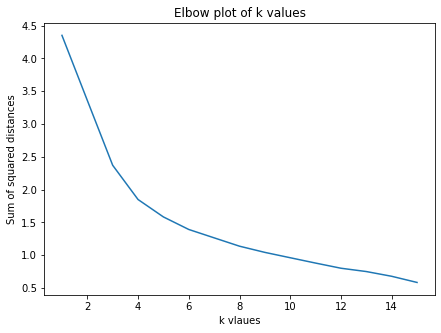

In [21]:
# Find number of clusters
import matplotlib.pyplot as plt
toronto_grouped_clustering = toronto_grouped.drop('Neighborhood', 1)

k_values = range(1,16)
sum_of_squared_dist = []
labels = []
for k in k_values:
    k_means = KMeans(init="k-means++", n_clusters=k, n_init = 12)
    k_means = k_means.fit(toronto_grouped_clustering)
    sum_of_squared_dist.append(k_means.inertia_)
    labels.append(k_means.labels_)

plt.figure(figsize=(7, 5))
plt.plot(k_values, sum_of_squared_dist) #, 'bx-')
plt.title("Elbow plot of k values")
plt.ylabel("Sum of squared distances")
plt.xlabel("k vlaues")
plt.show()

In [22]:
# set number of clusters (Elbow on graph at k=4)
kclusters = 4

# run k-means clustering
kmeans = KMeans(init="k-means++", n_clusters=kclusters, random_state=0).fit(toronto_grouped_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_ #[0:10] 

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 2, 1,
       1, 1, 1, 1, 0, 3, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], dtype=int32)

We create a new dataframe that includes the cluster as well as the top 10 venues for each neighborhood

In [23]:
# add clustering labels
neighborhoods_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)

toronto_merged = toronto_data

# merge toronto_grouped with toronto_data to add latitude/longitude for each neighborhood
toronto_merged = toronto_merged.join(neighborhoods_venues_sorted.set_index('Neighborhood'), on='Neighborhood')

toronto_merged.head()

,Postal Code,Borough,Neighborhood,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,M5A,Downtown Toronto,"Regent Park, Harbourfront",43.654260,-79.360636,1,Coffee Shop,Bakery,Pub,Park,Breakfast Spot,Café,Theater,Yoga Studio,Cosmetics Shop,Shoe Store
1,M7A,Downtown Toronto,"Queen's Park, Ontario Provincial Government",43.662301,-79.389494,1,Coffee Shop,Sushi Restaurant,Diner,College Cafeteria,Bar,Beer Bar,Smoothie Shop,Sandwich Place,Burrito Place,Café
2,M5B,Downtown Toronto,"Garden District, Ryerson",43.657162,-79.378937,1,Clothing Store,Coffee Shop,Middle Eastern Restaurant,Italian Restaurant,Cosmetics Shop,Bubble Tea Shop,Café,Japanese Restaurant,Ramen Restaurant,Fast Food Restaurant
3,M5C,Downtown Toronto,St. James Town,43.651494,-79.375418,1,Coffee Shop,Café,Gastropub,Cocktail Bar,American Restaurant,Restaurant,Clothing Store,Gym,Creperie,Moroccan Restaurant
4,M4E,East Toronto,The Beaches,43.676357,-79.293031,1,Trail,Pub,Health Food Store,Distribution Center,Department Store,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store,Yoga Studio


__Visualize clusters__

In [24]:
# create map
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=11)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(toronto_merged['Latitude'], toronto_merged['Longitude'], toronto_merged['Neighborhood'], toronto_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

### 5. Examine clusters

*Cluster 0 - family activities areas*

In [25]:
cluster_0 = toronto_merged.loc[toronto_merged['Cluster Labels'] == 0, toronto_merged.columns[[2] + list(range(5, toronto_merged.shape[1]))]]
cluster_0.drop('Cluster Labels', axis=1)

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
18,Lawrence Park,Park,Swim School,Bus Line,Yoga Studio,Department Store,Eastern European Restaurant,Dumpling Restaurant,Donut Shop,Doner Restaurant,Dog Run
21,"Forest Hill North & West, Forest Hill Road Park",Trail,Park,Jewelry Store,Sushi Restaurant,Deli / Bodega,Eastern European Restaurant,Dumpling Restaurant,Donut Shop,Doner Restaurant,Dog Run
33,Rosedale,Park,Playground,Trail,Yoga Studio,Dance Studio,Dumpling Restaurant,Donut Shop,Doner Restaurant,Dog Run,Distribution Center


*Cluster 1 - eating areas*

In [26]:
cluster_1 = toronto_merged.loc[toronto_merged['Cluster Labels'] == 1, toronto_merged.columns[[2] + list(range(5, toronto_merged.shape[1]))]]
cluster_1.drop('Cluster Labels', axis=1)

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,"Regent Park, Harbourfront",Coffee Shop,Bakery,Pub,Park,Breakfast Spot,Café,Theater,Yoga Studio,Cosmetics Shop,Shoe Store
1,"Queen's Park, Ontario Provincial Government",Coffee Shop,Sushi Restaurant,Diner,College Cafeteria,Bar,Beer Bar,Smoothie Shop,Sandwich Place,Burrito Place,Café
2,"Garden District, Ryerson",Clothing Store,Coffee Shop,Middle Eastern Restaurant,Italian Restaurant,Cosmetics Shop,Bubble Tea Shop,Café,Japanese Restaurant,Ramen Restaurant,Fast Food Restaurant
3,St. James Town,Coffee Shop,Café,Gastropub,Cocktail Bar,American Restaurant,Restaurant,Clothing Store,Gym,Creperie,Moroccan Restaurant
4,The Beaches,Trail,Pub,Health Food Store,Distribution Center,Department Store,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store,Yoga Studio
5,Berczy Park,Coffee Shop,Cocktail Bar,Bakery,Café,Beer Bar,Cheese Shop,Seafood Restaurant,Restaurant,Breakfast Spot,Irish Pub
6,Central Bay Street,Coffee Shop,Italian Restaurant,Sandwich Place,Japanese Restaurant,Café,Burger Joint,Department Store,Salad Place,Thai Restaurant,Bubble Tea Shop
7,Christie,Grocery Store,Café,Park,Restaurant,Diner,Baby Store,Italian Restaurant,Nightclub,Coffee Shop,Candy Store
8,"Richmond, Adelaide, King",Coffee Shop,Café,Restaurant,Gym,Thai Restaurant,Deli / Bodega,Hotel,Bookstore,Sushi Restaurant,Steakhouse
9,"Dufferin, Dovercourt Village",Bakery,Pharmacy,Supermarket,Middle Eastern Restaurant,Bar,Café,Bank,Music Venue,Brewery,Grocery Store


*Cluster 2 - exercise/sports areas*

In [27]:
cluster_2 = toronto_merged.loc[toronto_merged['Cluster Labels'] == 2, toronto_merged.columns[[2] + list(range(5, toronto_merged.shape[1]))]]
cluster_2.drop('Cluster Labels', axis=1)

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
29,"Moore Park, Summerhill East",Tennis Court,Yoga Studio,Deli / Bodega,Electronics Store,Eastern European Restaurant,Dumpling Restaurant,Donut Shop,Doner Restaurant,Dog Run,Distribution Center


*Cluster 3 - relaxation areas*

In [29]:
cluster_3 = toronto_merged.loc[toronto_merged['Cluster Labels'] == 3, toronto_merged.columns[[2] + list(range(5, toronto_merged.shape[1]))]]
cluster_3.drop('Cluster Labels', axis=1)

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
19,Roselawn,Garden,Yoga Studio,Deli / Bodega,Electronics Store,Eastern European Restaurant,Dumpling Restaurant,Donut Shop,Doner Restaurant,Dog Run,Distribution Center
